# Lecture 3 -  Sequencing technologies and file formats

## Prokaryote genome annotation and effect of read type and coverage

This tutorial will walk you trough the process of producing and annotating a reference-based *Wolbachia* genome using reads from different sequencing technologies. The aim is to compare the effect of read type on the prediction and annotation of genes, which ultimately depends on site call certainty, site read coverage, and assembly completeness.

During this tutorial, you will become familiar with different file formats commonly used in Bioinformatics. You will learn to identify the metadata and quality information encoded in the files, perform data manipulations, and convert files between formats. We will also go over the SAM/BAM file format, CIGAR strings, information filters, and statistics.

---

## 1. Prepare the environment

We will create a new environment that contains only the tools we will use during the practical. Currently, a couple of programs that we need create conflicts unsolvable by Conda. For that reason, the notebook is a PDF and you can copy-paste or write your commands in your command prompt instead of executing the code from the notebook.

For the tutorial, we need to download large read files from the Sequence Read Archive ([SRA](https://www.ncbi.nlm.nih.gov/sra)) using [sra-toolkit](https://hpc.nih.gov/apps/sratoolkit.html) commands. Follow the instructions below to install the toolkit. We will download the data in the background using the command `nohup` ([no hang up](https://en.wikipedia.org/wiki/Nohup). `nohup` allows you to continue working on the command line prompt without killing the processes that are running. If you feel adventurous, you can modify the code to download the data and run it as a loop.

After downloading the data below, **go to the course's learning environment and download the rest of files we will nned from the Lecture 3 folder.**

Additionally, you should install [Tablet](https://ics.hutton.ac.uk/tablet/). Tablet is a graphical viewer for next generation sequence assemblies and alignments available to must operative systems.

Go to [Tablet's download website](https://ics.hutton.ac.uk/tablet/download-tablet/), download the distribution that matches your machine (if you have Windows download the corresponding file), and install it.

---

## 2. Explore the fasta file

Explore the files within the folder, you will inmediately notice there are three types with the extensions `fasta`, `fastq`, and `gff3`. Let's look at `wolbachia.fasta` first.


<div class="alert alert-block alert-success">
<b>TO DO: </b>How many sequences are there in the <i>wolbachia.fasta</i> file? Append you answer to your <i>answersL3_name.txt</i> file using `>>`.</div>

**Try checking how long the sequence in the `wolbachia.fasta` file is.**

That file is an example of an **interleaved fasta** file, meaning that the sequence is split into lines with the same number of characters instead of keeping the whole sequence in a single line. However, having the sequence in a single line facilitates operations on the sequence. For example, finding the *nth* nucleotide of the sequence or finding patterns in the sequence. In an interleaved fasta file, you would need to know what is the number of characters per sequence line to be able ot find the *nth* nucleotide or will have to account for newline characters at any point of the pattern being searched.

**What is the difference between `grep` and `grep -v` ?**

We can use a single line awk command to transform an interleaved fasta into one with the sequence in a single line.

The breakdown of that `awk` command is:

`awk '/^>/` gets lines that start with the `>` symbol (i.e. fasta headers)
`{ if(NR>1) print "";  printf("%s\n",$0); next; }` effectively indicates AWK to not do anything if NR (numbered row) is larger than 1 and line starts with the `>` symbol. It tells AWK to print that line (the header) followed by a "new line" character `\n`. Then, the command tells AWK to go to the next line after the line that starts with `>` (i.e. the first line with sequence information).

`{ printf("%s",$0);}` prints any "next" line as long as it does not start with a `>`

`END {printf("\n");}'` tells AWK to finish iterating through all "next" lines as long as they don't start with a `>` and to add a "new line" character `\n` at the end.

`< wolbachia.fasta` inputs file as StdIn
`> wolbachiaSL2.fasta` redirects the output of the AWK command to a new file.

**What is the number of nucleotides in the sequence?** 

<div class="alert alert-block alert-success">
<b>TO DO: </b>What is the number of nucleotides in the sequence? Is the count different between the interleaved and single line fasta files? Append you answer to your <i>answersL3_name.txt</i> file using <i>>></i>.</div>

---

## 3. Explore the fastq files

Now, check out the `SRR10988554.fastq` file.

**How does it compare to the `*fasta` file? Which pattern can you identify?**

Unlike fasta files, fastq files have four lines: The header, the sequence, the annotation line, and the quality line. the latter contains the same about of symbols as the number of nucleotides in the sequence and each symbol (an [ASCII character](https://www.ascii-code.com/)) represents a **quality score** of the identification of the base called, or in other words, the accuracy of the base calling. That score is known as the [**Phred score**](https://en.wikipedia.org/wiki/Phred_quality_score)

Check out the following files:

`SRR10988554.fastq`, `SRR10988554_1.fastq`, and `SRR10988554_2.fastq`

**Which one is larger? How many lines are in each file?**

<div class="alert alert-block alert-success">
<b>TO DO: </b>Which symbol represents the header and read information line? How many reads are in each file? Use <i>echo</i> and <i>>></i> to append the name of each file to the <i>answersL3_name.txt</i> file, then append the read count using your own code.    

        
You might have noticed that the symbol marking the header line is also an ASCII character used for encoding base quality. <b>How can you correctly count the reads whilst avoiding counting the symbol when it only represents base quality?</b>

</div>

You now know how many reads there are in each file but, why do you think you have three files?

We can check at the header of a couple of reads. The header contains the SRA accession number followed by a `.` and the number of the read, then a code that uniquely identifies that read, and finally, the read's length. We can pick a random read identifier and use `grep` to check what we find:


Can you see a pattern?

You can at least tell the type of **read-paring** from looking at the files associated with the `SRR10988554` data.

Now, we can also guess which sequencing technology was used for generating all data files based on the length of the reads. We can pipe a couple of commands to `grep` the header line, then select only the *field* containing the length information, and finally sort the read lengths to obtain the minimum and maximum read lengths. There are several solutions to this problem.


<div class="alert alert-block alert-success">
<b>TO DO: </b>Share the code you use to find the <b>minimum and maximum read lengths</b> in all <i>SRR10988554*fastq</i> files, as well as the numbers. Append the answers to your <i>answersL3_name.txt</i> file.</div>

<!--grep '^@SRR' SRR10988554_1.fastq | cut -d" " -f 3 | sed 's/length=//g' | sort -n | uniq | tail -->
<!--  454 GS FLX -->
There are unexpectedly long reads. Let's find the header and the context lines to check if it is an error or not.

### 3.1. Phred scores

That particular read is extrange. Looks repetitive and the Phred scores are mainly `!`, `*`, `)`. **Would you trust that read? what can you tell about it?**

Below you can see the characters used by the most common sequencing technologies to encode quality. The image is taken from [here](https://en.wikipedia.org/wiki/FASTQ_format)

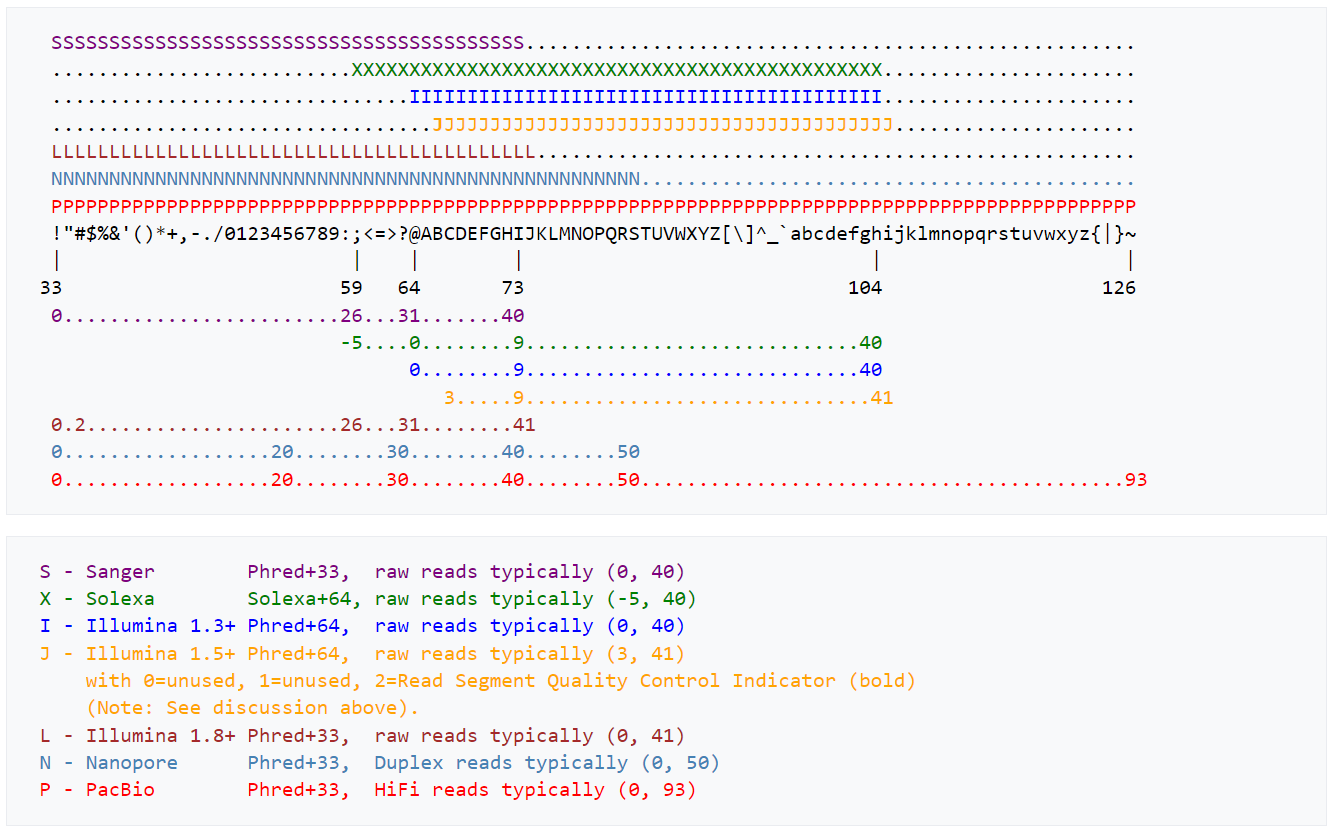

The **Phred quality scores** can be interpreted as the probability that the nucleotide called for a particular site is an error. You can see the reference table source from [here](https://en.wikipedia.org/wiki/Phred_quality_score) as an exmaple of that rationale.

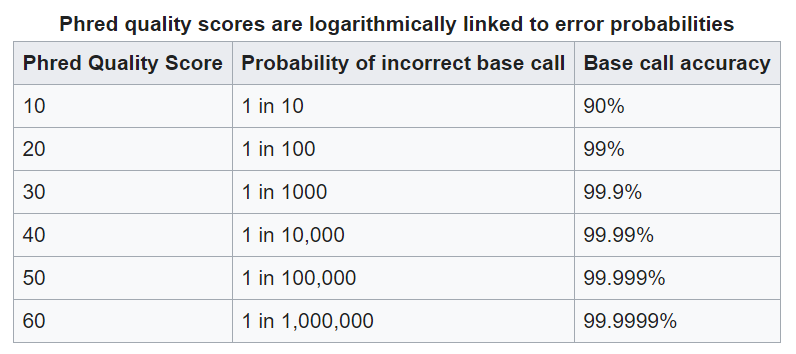

The characters `!` and `"` symbolise the two worst Phred scores in most files generated by most sequencing technologies. We can identify how many reads have only `!` or `"` as quality scores for all positions within the read.

What about reads that only have calls with the best score? How many reads wiht only `I` as Phred score character?

Let's look at the other fastq files that we downloaded. 

Have a look at the files, count the length of the reads, check if the reads are paired-end or not, and figure out which are the likely sequencing technologies used for generating that data.

<div class="alert alert-block alert-success">
<b>TO DO: </b>Which sequencing technologies are used for generating the <b>SRR10988554</b> and <b>DRR353013</b> data? Append the answers to your <i>answersL3_name.txt</i> file.</div>

---

## 4. Reference-based genome assemblies from read alignments

One approach to genome or transcriptome assemblies is to generate reads (from any sequencing technology) and map it to a reference genome that is already available and that belongs to the same or a very, very closely related relative species/lineage.

We will discuss reference-based assemblies in more depth later during the course. For now, we will use the approach as an excuse to generate SAM and BAM files showing the reads mapped to the reference assembly. To achieve this, **run the `curl` command below in your command line. Then, decompress the zip file using the `unzip` command.** If the `zip` command doesn't work, you can go to Windows explorer (or the MacOS, Linux equivalent) and unzip the file.

Go into the `ncbi_dataset/data/GCF_016584425.1/` folder and identify the files inside. Create a variable to point to the file with the reference genome assembly we just downloaded.

We will use [Minimap2](https://lh3.github.io/minimap2/minimap2) to map the reads we downloaded to *Wolbachia*'s reference genome. The output will be a SAM fine in binary format (BAM) and we will use [samtools](https://www.htslib.org/doc/#manual-pages) to manipulate, query, and filter SAM/BAM files.

A breakdown of the code below goes as:

`minimap -t 4 -ax sr $REF File1 File2` instructs minimap to use 4 threads (`-t`) to produce a SAM file (`-a`) from mapping paired-end short reads (`x sr`) in files `File1` and `File2` against the reference in `$REF`.

The output of that command is then "piped" to [samtools](https://www.htslib.org/doc/#manual-pages) to `sort` the resulting alignments by coordinate (default, with respect to the reference seqquence) using 4 threads (`-@`)

The result from the latest command is piped to [samtools](https://www.htslib.org/doc/#manual-pages) `view` to produce a BAM file with headers (`-hb`).

Run the commands for each of the read files. You can take a break whilst this step is running.

To visualise the BAM files uwing Tablet, we need to index the BAM files. Indexing allows for a faster andmore efficient search for sequence patterns.

### 4.1. The SAM and BAM files

**SAM (Sequence Alignment/Map) files and their binary version BAM files** are text-based files that store information about the alignment of short or long DNA sequences (reads) to a reference genome.

Each line represents a single read and includes details such as the read name, sequence, alignment position, mapping quality, etc.

SAM files can be stored as binary to decrease file size, although the files are not human-readable in binary format.

SAM/BAM usually represent alignments for a single sample or a single sequencing experiment; they constitute common input files for variant calling programs.

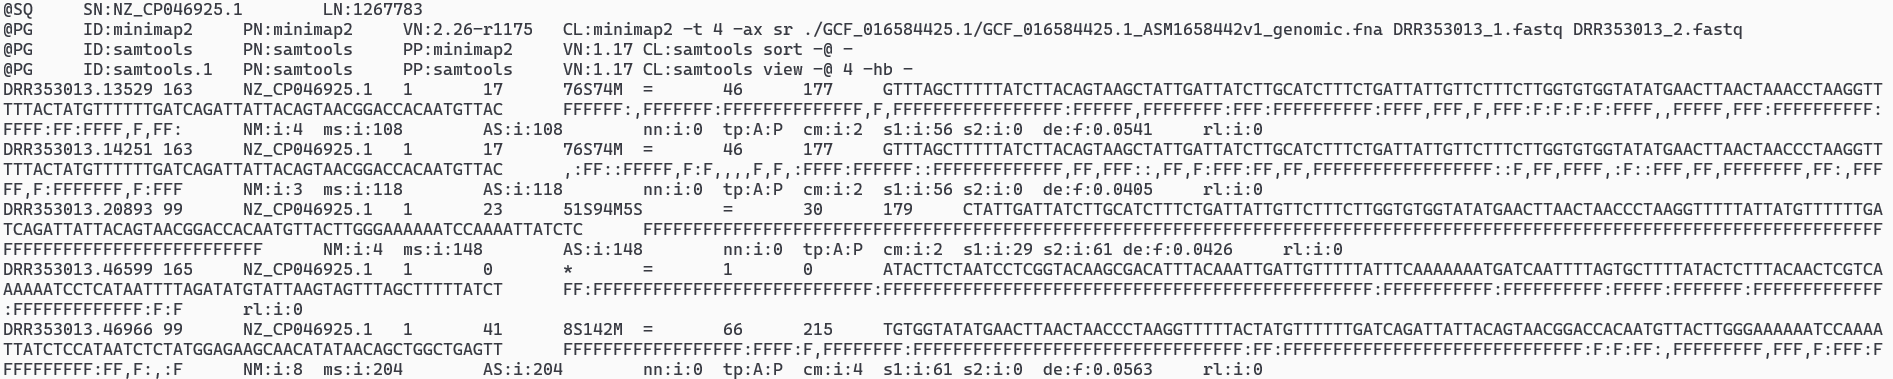

The header lines start with a `@` symbol.

The alignment lines have at least 11 columns (plus additional ones) in the following order (and using this first line as an example)
`DRR353013.13529 163     NZ_CP046925.1   1       17      76S74M  =       46      177     GTTTAGCTTTTTATCTTACAGTAAGCTATTGATTATCTTGCATCTTTCTGATTATTGTTCTTTCTTGGTGTGGTATATGAACTTAACTAAACCTAAGGTTTTTACTATGTTTTTTGATCAGATTATTACAGTAACGGACCACAATGTTAC      FFFFFF:,FFFFFFF:FFFFFFFFFFFFFF,F,FFFFFFFFFFFFFFFFF:FFFFFF,FFFFFFFF:FFF:FFFFFFFFFF:FFFF,FFF,F,FFF:F:F:F:F:FFFF,,FFFFF,FFF:FFFFFFFFFF:FFFF:FF:FFFF,F,FF:      NM:i:4  ms:i:108        AS:i:108        nn:i:0  tp:A:P  cm:i:2  s1:i:56 s2:i:0  de:f:0.0541     rl:i:0`

**1. QNAME Query read name** DRR353013.13529

**2. FLAG Read flag** 163 - check this tool to decode flags [**here**](https://broadinstitute.github.io/picard/explain-flags.html) 

**3. RNAME Reference name** NZ_CP046925.1

**4. POS Starting coordinate** 1 - 1-basedleftmostmapping

**5. MAPQ Mapping quality** 17  - *−10log10Pr{mappingpositioniswrong}* roundedtothenearest integer (>20 is a rule of thumb depending on the application)

**6. CIGAR** 76S74M

**7. RNEXT Reference seq name of 1ry aln of the next read in template** =

**8. PNEXT Starting coordinate of the 1ry aln of the next read in template** 46 - 1-based

**9. TLEN Template lenght** 177 - distance between the mapped end of the template and the mapped start of the template, inclusively

**10. SEQ Sequence** GTTTAGCTTTTTATCTTACAGTAAGCTATTGATTATCTTGCATCTTTCTGATTATTGTTCTTTCTTGGTGTGGTATATGAACTTAACTAAACCTAAGGTTTTTACTATGTTTTTTGATCAGATTATTACAGTAACGGACCACAATGTTAC

**11. QUAL Sequence quality** FFFFFF:,FFFFFFF:FFFFFFFFFFFFFF,F,FFFFFFFFFFFFFFFFF:FFFFFF,FFFFFFFF:FFF:FFFFFFFFFF:FFFF,FFF,F,FFF:F:F:F:F:FFFF,,FFFFF,FFF:FFFFFFFFFF:FFFF:FF:FFFF,F,FF: - ASCII of base quality plus 33 (same as Sanger Fastq)

In our case, the flag 163 means (screenshot taken from Broad Institute's decoding tool website)

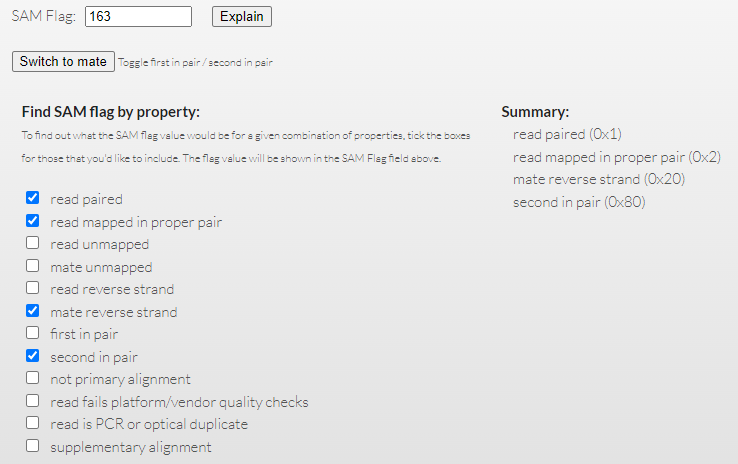

The **CIGAR** string also encodes detailed information about the alignments (taken from SAM/BAM's official documentation [here](https://samtools.github.io/hts-specs/SAMv1.pdf)

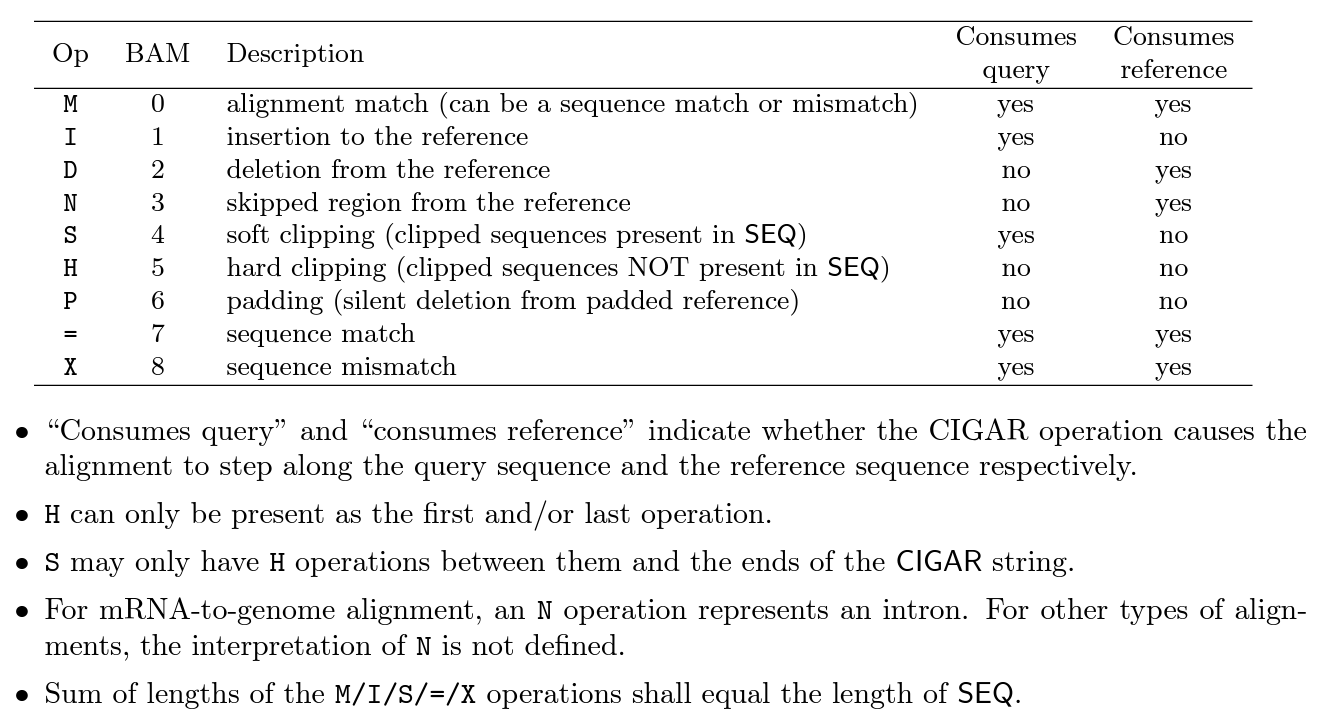

so, a CIGAR string that looks like **3M2X** means that the query sequence (our read) aligns to the reference genome with **3 matches and 2 mismatches**. the table above shows the meaning of the letters in the human-readable SAM or `zcat bam` and the bits (BAM column) as it would look like in the binary format.

Another useful distinction about sequence mapping that we will cover later is "soft" and "hard" clipping of query sequences with respect to the reference. In the alignment, **soft clipping** keeps the bases of the sequence that do not align in the file, whereas **hard clipping** removes those bases from the file. You can think of it as "ignoring the mistmatches and keeping them for later" versus "disappearing them completely".

<div class="alert alert-block alert-success">
<b>TO DO: </b>What does this CIGAR string mean? <b>16M2I7M1D19M1I10M1I9M1I18M1I15M1D13M2I13M2I6M1I7M5186H</b> Append the answers to your <i>answersL3_name.txt</i> file.</div>

One way to explore a SAM/BAM file is by combining `samtools view` and Linux commands. For example, we can plot a histogram showing the distribution of template length (column 9).

We can also count the number of mapped (a single or multiple alignment) and not mapped reads:

<!-- 133 read paired (0x1) read unmapped (0x4) second in pair (0x80) -->
<!-- 2225 read paired (0x1) read reverse strand (0x10) mate reverse strand (0x20) second in pair (0x80) supplementary alignment (0x800) -->

<div class="alert alert-block alert-success">
<b>TO DO: </b>How many read alignments are all of the following? <b>read paired, reverse strand, mate reverse strand, second in pair, and a supplementary alignment?</b> Append the answers to your <i>answersL3_name.txt</i> file.</div>

We can use `samtools depth` to calculate the read depth (or read coverage) at every position of the reference genome and plot a histogram. `samtools depth` outputs three columns: contig name, position, and read depth, all in a TAB delimited format.

Depending on the application, sometimes it is necesary to calculate the average read depth across the whole reference genome. For this, we can pipe the output from `samtools depth` into an AWK function.
<!-- 174.999 -->

<!-- for file in
*bam; do echo $file; samtools depth -a $file | awk '{c++;s+=$3} END {print s/c}'; done

wol_DRR351748.bam 152.137
wol_DRR353013.bam 174.999
wol_ERR10558085.bam 221.311

wol_DRR351748.bam 115.661
wol_DRR353013.bam 93.4905
wol_ERR10558085.bam 221.311 !-->

<div class="alert alert-block alert-success">
<b>TO DO: </b>Calculate the average read depth for the three BAM files: wol_DRR351748.bam, wol_DRR353013.bam, and wol_ERR10558085.bam. <b>Which file has deeper read coverage if only sites with reads mapped are included? Which file has deeper coverage when including all sites? </b> Append the answers to your <i>answersL3_name.txt</i> file.</div>

`samtools` has other commands that allow you to get statistics about the proportion of reads mapped to the reference, how many of those reads correspond to single or paired-end mates, and how many (if they are paired-end) are mapping with their corresponding mate.

We could run the `samtools flagstat` command to calculate the stats one file at a time or we could use a loop and `nohup`.

<div class="alert alert-block alert-success">
<b>TO DO: </b>Which file has a higher percentage of reads mapped to the reference? Which file has a higher percentage of reads mapping to a primary alignment? Append the answers to your <i>answersL3_name.txt</i> file.</div>

<!--wol_DRR351748.flagstat
85253 + 0 mapped (48.56% : N/A first question)
44633 + 0 primary mapped (33.07% : N/A)
wol_DRR353013.flagstat
901120 + 0 mapped (27.03% : N/A)
897225 + 0 primary mapped (26.95% : N/A)
wol_ERR10558085.flagstat
31491 + 0 mapped (45.81% : N/A)
28958 + 0 primary mapped (43.74 second question --!> % : N/A)

The stats generated by `samtools flagstat` command are not very detailed and only concern read flags, but we can get more comprehensive information using `samtools stats`. the report generated comes with code suggestions for users to extract the information and summarise it.

Amongst the things `samtools stats` report is the Insert size and Read length.

Each sequencing technology has different **insert sizes** (the sequence in between primers and indices that actually belongs to the organism and is not added during library preparation) (Figure taken from [Illumina knowledge website](https://knowledge.illumina.com/library-preparation/general/library-preparation-general-reference_material-list/000003874)

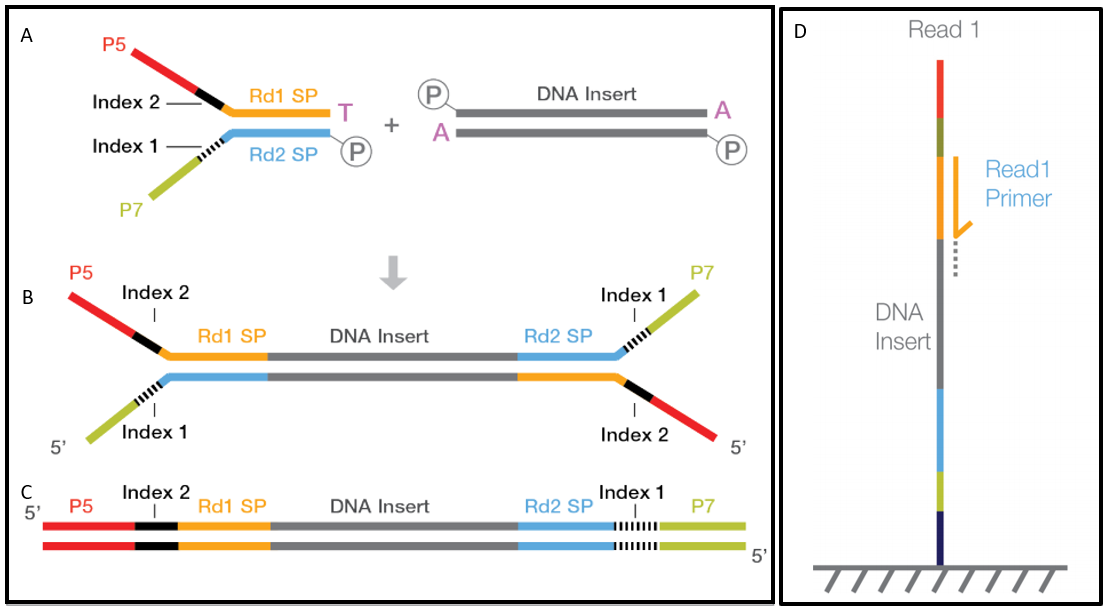

...and different **read lengths** (the length of the fragment being sequenced with indices, barcodes, primers, etc. included) (Figure from [Garg 2021](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02328-9))

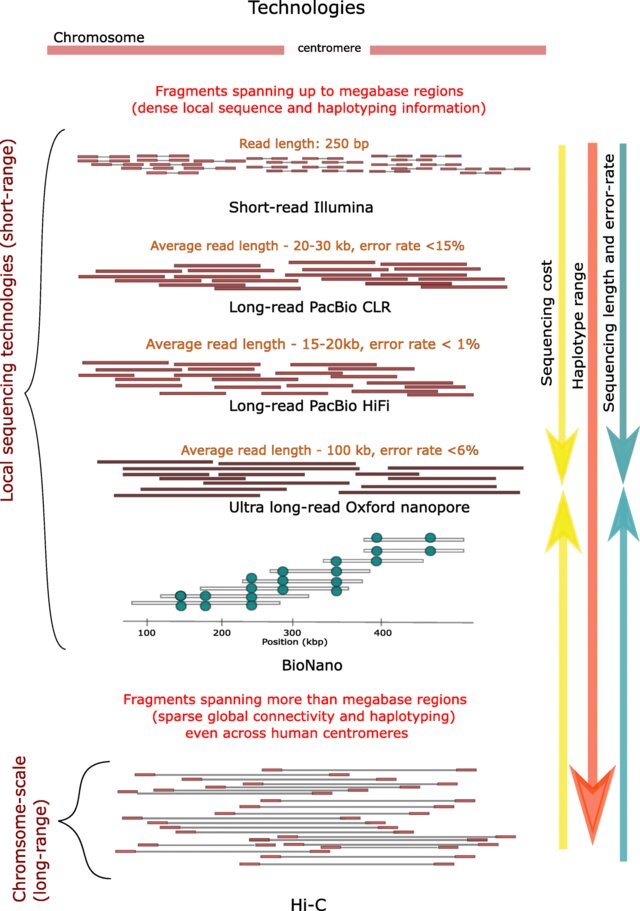

<div class="alert alert-block alert-success">
<b>TO DO: </b>Run the loops and plot the histograms above. Look at the insert sizes for each sample and at the read lenght from each sample. Considering both, <b>which sequencing technology was most likely used for each sample? Did you notice something strange?</b> Append the answers to your <i>answersL3_name.txt</i> file. A hint: Insert sizes can only be estimated for reads that map correctly and for which their pair also maps correctly.</div>

<!--
wol_DRR351748.stats pacbio sequel no insert size
mean read length 12k and max is 46k

wol_DRR353013.stats illumina novaseq - weird >8000 insert sizes
mean read lenght 125 with max 150 nucleotides

wol_ERR10558085.stats minion no insert size
mean read length of 12k with max 90k
uest% : N/A)

Other interesting stats are Coverage distribution and Mapping qualities.

**Coverage distribution** indicates the read depth at different points of the reference genome and can help identify the presence of repetitive regions in the reference genome. For example, at an expected 50x coverage of a diverse genome, the coverage distribution would be centered with mean 50. If the genome has repetitive regions, we would expect different peaks at multiples of 50.

**Mapping qualities** are calculated for mapping reads and are a good indication of the presence/absence of genomic features that differ between the reference genome and the sequenced samples, as well as the quality of the sequencing (e.g. for whole-genome sequencing, is the whole genome indeed represented by reads?)

<div class="alert alert-block alert-success">
<b>TO DO: </b>Run the loop above to extract mapping quality information. <b>Which file has better mapping quality on average?</b> Append the answers to your <i>answersL3_name.txt</i> file.</div>

<!--
wol_ERR10558085.stats
30.775 --!>9

---

## 5. Consensus sequences from reference-read alignments

### 5.1. VCF and BED formats

Up to now, we downloaded three sets of reads generated using different sequencing technologies. We mapped the reads to the same reference genome and we are about to evaluate what is the effect of read sequence technology and read coverage (in terms of depth and along the reference) in **1)** quality of the consensus sequence obtained from the allignments; and **2)** the subsequent results of a quick gene annotation exercise.

So, first, we will construct the consensus sequence from the BAM files. This procedure is effectively the same as to assembling a reference-based genome without using additional assemblers for correction. Keep in mind that we are skipping some cleaning steps that should be carried out for obtaning a high-quality genome assembly.

`bcftools consensus` creates the consensus sequence from a VCF (Variant Calling File, to which we will devote more time and depth in a few lecture's time). To generate the VCF, we first call `bcftools mpileup` which takes the information for each site from one or multiple BAM files and transform the annotations into columns. The output from that command is directly piped to `bcftools call` which is tasked with calling the base variants at each side based on the read/site quality and flags annotated and organised by `samtools`.

`bcftools call` uses multiple models to call the variants. Here, we are using all the default settings expect for output format (`-O z`) to obtain a compressed (binary) VCF and we are providing `bcftools` with a **BED** file indicating the ploidy of every contig in the reference. `bcftools` assumes contigs are diploid by default, but we are working with *Wolbachia*, which contains a circular (though we work as if it was linear) haploid genome. 

The **BED format** is a TAB-delimited file where the rows represent a region in the reference genome (sometimes is a chromosome, sometimes is a contig) and the columns represent annotations, more often the starting coordinate, ending coordinate, sex of the organism, ploidy of the organism at that site.

Remember, **input BAM files must be sorted by coordinate!**

Generating a **BED** file is relatively straightforward. We can use the header from the BAM files and add the rest of the information using AWK. Since the reference is the same for our three BAM files, we can generate the BED file from only one BAM and use it for the three.

We only have one contig in the reference and creating the file by hand is an option, but it is useful to create code for when the reference has multiple contigs.

We can now go ahead and create the VCFs

Before proceeding, we can look at the **VCF** to understand the basic information it encodes. We will go back to VCFs in the future and we will be looking at the annotations in the header and variant sections.

The first five columns contain information about the site position and base at the reference:

**#CHROM:** NZ_CP046925.1 - contig name  
**POS:** 1 - 1-based position  
**ID:** . - of the reference if provided  
**REF:** A   
**ALT:** . - is the base from the read data, i.e. the alternative allele. A dot means that the base here is the same as the base in the reference, in this case A  
**QUAL:** 195.987 - quality of the call  
**FILTER:** . - none applied  
**INFO:** DP=76;MQ0F=0;AF1=0;AC1=0;DP4=55,0,0,0;MQ=30;FQ=-192.988 - contains information about the variant  
**FORMAT:** GT:PL - contains information related to the allele/variant for each sample. Here we have GenoType and ProbabiLity for a single sample called wol_DRR353013.bam  
**wol_DRR353013.bam:** 0/0:0 - The allele/variant information for this samples with the header described in FORMAT.

When the VCF file is produced from multiple-sample BAM files, the SAMPLE column repeats for each of the BAM files used.

Now, let's create the consensus using `bcftools consensus`. For that, we also need to reformat the compressed VCFs and index them using `bgzip` for compression and `tabix` for indexing.

---

## 6. Gene annotation

Now we will use [prokka](https://academic.oup.com/bioinformatics/article/30/14/2068/2390517?login=false) to annotate "on the fly" genes from the three *Wolbachia* genomes we assembled from three types of data. On thefly means that we are not exploting all the functionalities that [prokka](https://github.com/tseemann/prokka) has nor that we are leveraging the data available out there to achieve a complete high-quality annotation. But our approach is enough to compare gene annotations between data types to understand why is the effect of having short or long reads from different accuracies in the completeness and number of genes predicted.

### 6.1. Fasta, GenBank, and GFF files

Each annotation generates 12 files summarising the finding. Of those, we are interesting in these files (using the wol_DRR353013 sample as our example)

**PROKKA_09202023.faa** This is a fasta file that contains the protein sequences (amino acid sequences) that are translated from the nucleotide sequences identified as codding regions by prokka. The header contains the code for the predicted protein and it connects data across files. The header also contains the name of the protein as it appears in GenBank databases.  

**PROKKA_09202023.ffn** This is a fasta file with the nucleotide sequences corresponding to the aminoacid sequences in the file above.  

**PROKKA_09202023.gff** The General Feature Format file ([GFF](https://www.ensembl.org/info/website/upload/gff.html)) is a TAB-delimited file that contains a description of the regions delimited within the sequences, i.e. gene and general sequence annotations. The columns show contig name (or chromosome), the source which is in this case the [Prodigal](https://github.com/hyattpd/Prodigal gene prediction identifier, the type of feature, the start of the feature, the end of the feature, the score (not in our files), the strand, the frame in 0-indexed format, and additional annotations in a semi-colon separated format.  

**PROKKA_09202023.tsv** Which is another TAB-delimited file that summarises the additional annotations present in the last column of the *.gff file. 

**PROKKA_09202023.gbk** Is a file in the GenBank format with the data and metadata for the features predicted in our genomes. The format resembles the formatting displayed in GenBank websites and it is designed to be human readable. However, it is not the most machine-readable format due to the space characters and other formatting features.  

**PROKKA_09202023.txt** Is a short summary about the main results.

Let's print the summary for all three data types:

<div class="alert alert-block alert-success">
<b>TO DO: </b>Which type of data has more CDSs (coding sequences) predicted? Which type of data has the least? If you could guess which type of data you have from the previous questions, <b>How does the data or read type affect the number of predicted CDSs?</b> Append the answers to your <i>answersL3_name.txt</i> file.</div>

<div class="alert alert-block alert-success">
<b>TO DO: </b>Check out the GFF files with predictions and annotations for all three data types. For each data type, create an AWK command to estimate the length of the predicted CDS from the start and end of the feature columns and plot a histogram (with the same number of bins). <b>Describe the distribution of CDS lengths for each data type</b> Append the answers to your <i>answersL3_name.txt</i> file.</div>

Further visualisation of the reference genome and reads mapped to it, in addition to the GFF annotations we generated can be done using [Tablet](https://tablet.hutton.ac.uk/en/latest/protein_translations.html)